# EM casing response dipole source

In [1]:
import numpy as np
import scipy.sparse as sp
import pandas as pd
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize
from matplotlib import cm as colormap
import time
from string import ascii_lowercase
import pickle
from multiprocessing import Pool

# SimPEG, discretize/
import discretize
from discretize import utils
from SimPEG.electromagnetics import frequency_domain as fdem
from SimPEG import utils, maps, Report
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casing_sim

In [2]:
path_to_data = "/t40array/lheagy/casing-permeability"

In [3]:
from matplotlib import rcParams
rcParams["font.size"] = 16

In [4]:
save_figures = False
fig_dir_high = "figures"
fig_dir_low = "low-rez-figures"

dpi_high=400
dpi_low=150

## Simulation parameters

In [6]:
run_simulations = True
directory = f"{path_to_data}/fields_dipole_fdem_1km"

In [7]:
import os
if not os.path.exists(directory):
    os.makedirs(directory)

In [24]:
# conductivities
sigma_air = 1e-4
sigma_back = 1e-1
sigma_casing = 5e6
mur_casing = np.r_[1, 50, 100, 150, 200]

# casing geometry
casing_b = 5e-2  
casing_t = np.r_[5e-3, 7.5e-3, 10e-3, 12.5e-3, 15e-3, 20e-3]
casing_a = np.array([casing_b - t for t in casing_t])
casing_l = 1000

In [25]:
# diffusion distance
1260 * np.sqrt(1/sigma_back)

3984.469851812158

In [27]:
src_dz = 10
src_z = np.r_[-100, -250, -500, -950, -1000, -1050]

In [28]:
csz = 2.5
npadz = 17
pf = 1.5

hx = casing_sim.mesh.pad_for_casing_and_data(
    casing_b,
    csx1=casing_t.min()/4., 
    npadx=11,
    csx2=25,
    domain_x=500
)

# Theta discretization
ny = 1
hy = np.ones(ny)
hy = hy*2*np.pi / hy.sum()

# vertical discretization
ncz = np.max([casing_l, np.max(np.abs(src_z))])/csz
hz = discretize.utils.unpack_widths([(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)])

# create the mesh
mesh = discretize.CylindricalMesh([hx, hy, hz], x0=np.r_[0,0,-hz[:-npadz].sum()])
print(mesh.n_cells)

49940


/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:247: FutureWarning: meshTensor has been deprecated, please use unpack_widths. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


In [29]:
frequencies = np.logspace(-1, 2, 31) 

print(503/np.sqrt(sigma_back*frequencies))
print(503/np.sqrt(sigma_casing*frequencies))

[5030.         4482.99221881 3995.47102066 3560.96729545 3173.71544274
 2828.57686571 2520.97178515 2246.81846852 2002.47906788 1784.71134784
 1590.62566306 1417.64661443 1263.47887505 1126.0767327  1003.61694443
  894.47454325  797.20127581  710.50638495  633.23948213  564.37528251
  503.          448.29922188  399.54710207  356.09672955  317.37154427
  282.85768657  252.09717851  224.68184685  200.24790679  178.47113478
  159.06256631]
[0.71134942 0.63399084 0.56504493 0.50359682 0.44883114 0.40002118
 0.35651925 0.31774812 0.28319331 0.2523963  0.22494844 0.20048551
 0.1786829  0.1592513  0.14193287 0.1264978  0.11274129 0.10048078
 0.08955359 0.07981472 0.07113494 0.06339908 0.05650449 0.05035968
 0.04488311 0.04000212 0.03565192 0.03177481 0.02831933 0.02523963
 0.02249484]


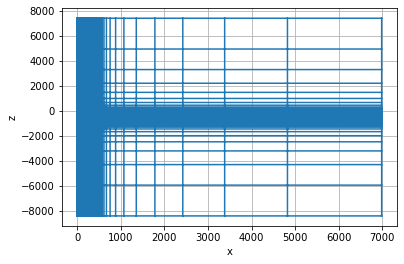

In [30]:
ax = mesh.plot_grid()

In [31]:
def get_casing_inds(ca):
    inds_casing_x = (
        (mesh.cell_centers[:, 0] > ca) & 
        (mesh.cell_centers[:, 0] < casing_b)
    )
    inds_casing_z = (
        (mesh.cell_centers[:, 2] < 0) &
        (mesh.cell_centers[:, 2] > -casing_l)
    )
    return inds_casing_x & inds_casing_z

In [32]:
mur_casing

array([  1,  50, 100, 150, 200])

In [33]:
models = {}

halfspace_conductivity = sigma_back * np.ones(mesh.n_cells)
halfspace_conductivity[mesh.cell_centers[:, 2] > 0] = sigma_air

models[f"halfspace"] = {
    "sigma": halfspace_conductivity, 
    "mur": np.ones(mesh.n_cells)
} 
    
for i, t in enumerate(casing_t): 
    inds_casing = get_casing_inds(casing_a[i])
    casing_conductivity = halfspace_conductivity.copy()
    casing_conductivity[inds_casing] = sigma_casing

    for mur in mur_casing:
        key = f"casing_{mur:1.0f}_{t:1.2e}"
        casing_mur = np.ones(mesh.n_cells)
        casing_mur[inds_casing] = mur
        casing_permeability = casing_mur
        models[key] = {
            "sigma": casing_conductivity, 
            "mur": casing_permeability
        }


In [34]:
for i, t in enumerate(casing_t): 
    inds_casing = get_casing_inds(casing_a[i])
    for mur in mur_casing: 
        s_casing = sigma_casing * mur
        key = f"conductive_casing_{s_casing:1.0e}_{t:1.2e}"
        
        casing_conductivity = halfspace_conductivity.copy()
        casing_conductivity[inds_casing] = s_casing
        
        models[key] = {
            "sigma": casing_conductivity, 
            "mur": np.ones_like(casing_conductivity)
        }

In [35]:
def plot_casing(ax, model): 
    xlim = 0.22*np.r_[-1, 1]
    zlim = np.r_[-700, 50]
    pcolor_opts={"norm":LogNorm(), "cmap":"Spectral_r"}
    out = casing_sim.view.plot_slice(
        mesh, model, pcolor_opts=pcolor_opts, ax=ax,
    )
    out[-1].set_label("conductivity (S/m)")
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)

    ax.text(xlim[0]*0.9, -675, f"background: {1/sigma_back:1.0f} $\Omega$m", fontsize=16)
    ax.text(xlim[0]*0.9, 10, f"air: {1/sigma_air:1.0e} $\Omega$m", color="w", fontsize=16)
    ax.text(casing_b+0.01, -300, f"casing:\n{sigma_casing:1.0e} S/m\n$\mu>\mu_0$", fontsize=16)
#     for sign in np.r_[-1, 1]: 
#         ax.arrow(
#             0, -casing_l+60, casing_a*sign, 0, length_includes_head=True, shape="full", width=1e-2,
#             head_length=1e-2, head_width=10, color="k"
#         )

#         ax.arrow(
#             0, -casing_l-8, casing_b*sign, 0, length_includes_head=True, shape="full", width=1e-2,
#             head_length=1e-2, head_width=10, color="k"
#         )
#     ax.text(0, -casing_l+25, f"{casing_a*1e2*2:1.0f} cm", ha="center")
#     ax.text(0, -casing_l-45, f"{casing_b*1e2*2:1.0f} cm", ha="center")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    return ax

In [36]:
models.keys()

dict_keys(['halfspace', 'casing_1_5.00e-03', 'casing_50_5.00e-03', 'casing_100_5.00e-03', 'casing_150_5.00e-03', 'casing_200_5.00e-03', 'casing_1_7.50e-03', 'casing_50_7.50e-03', 'casing_100_7.50e-03', 'casing_150_7.50e-03', 'casing_200_7.50e-03', 'casing_1_1.00e-02', 'casing_50_1.00e-02', 'casing_100_1.00e-02', 'casing_150_1.00e-02', 'casing_200_1.00e-02', 'casing_1_1.25e-02', 'casing_50_1.25e-02', 'casing_100_1.25e-02', 'casing_150_1.25e-02', 'casing_200_1.25e-02', 'casing_1_1.50e-02', 'casing_50_1.50e-02', 'casing_100_1.50e-02', 'casing_150_1.50e-02', 'casing_200_1.50e-02', 'casing_1_2.00e-02', 'casing_50_2.00e-02', 'casing_100_2.00e-02', 'casing_150_2.00e-02', 'casing_200_2.00e-02', 'conductive_casing_5e+06_5.00e-03', 'conductive_casing_2e+08_5.00e-03', 'conductive_casing_5e+08_5.00e-03', 'conductive_casing_8e+08_5.00e-03', 'conductive_casing_1e+09_5.00e-03', 'conductive_casing_5e+06_7.50e-03', 'conductive_casing_2e+08_7.50e-03', 'conductive_casing_5e+08_7.50e-03', 'conductive_casi

/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1025: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1059: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:140: FutureWarning: CylMesh has been deprecated, please use CylindricalMesh. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.isSymmetric has been deprecated, please use CylindricalMesh.is_symmetric. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:217: FutureWarning: CylMesh.plotImage has been deprecated, please use CylMesh.plot_image. It will be removed in version 1.0.0

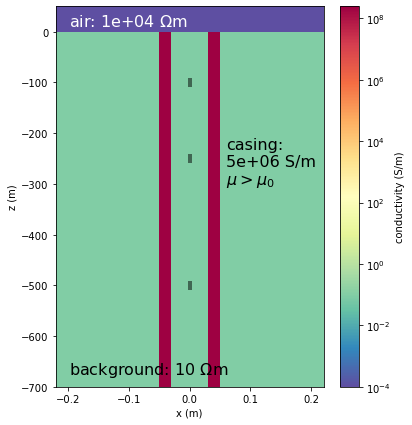

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6, 7))

key = "conductive_casing_2e+08_2.00e-02"

plot_casing(ax, models[key]["sigma"])

for loc in src_z:
    ax.plot(np.r_[0, 0], loc + src_dz/2*np.r_[-1, 1], "-k", lw=4, alpha=0.5)

## set up the simulations

In [38]:
def generate_simulation(mur):
    src_list = []
    for loc in src_z:
        src_locations = np.array([
            [0, 0, loc+src_dz/2.],
            [0, 0, loc-src_dz/2.]
        ])
        for f in frequencies: 
            src = fdem.sources.LineCurrent([], location=src_locations, frequency=f)
            src_list.append(src)
        
    survey = fdem.Survey(src_list)
    sim = fdem.simulation.Simulation3DMagneticField(
        mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
        survey=survey, solver=Pardiso, mu=mur * mu_0
    #     verbose=True
    )
    return sim


In [39]:
def load_fields(name, conductivity, mur):
    solution = np.load(f"{directory}/fields_{name}.npy")
    sim = generate_simulation(mur)
    sim.model = conductivity
    f = sim.fieldsPair(sim)
    f[:, sim._solutionType] = solution
    return f

In [40]:
if run_simulations: 
    mesh.save(f"{directory}/mesh.json")
    np.save(f"{directory}/frequencies", frequencies)
    with open(f"{directory}/models.pkl", "wb") as fp:
        pickle.dump(models, fp)

In [41]:
def run_simulation(key):
    t = time.time()
    print(f"starting {key}\n")
    sim = generate_simulation(models[key]["mur"])
    f = sim.fields(models[key]["sigma"])
    np.save(f"{directory}/fields_{key}", f[:, f"{sim._solutionType}"])
    print(f" ... done {key}. {time.time()-t:1.2e} s")
    return 

In [42]:
models["halfspace"]

{'sigma': array([0.1   , 0.1   , 0.1   , ..., 0.0001, 0.0001, 0.0001]),
 'mur': array([1., 1., 1., ..., 1., 1., 1.])}

In [43]:
# run_keys = [k for k in models.keys() if k not in fields.keys()]
# print(run_keys)

In [46]:
if run_simulations:   
    with Pool(32) as p:
        p.map(run_simulation, list(models.keys()))  

starting casing_1_7.50e-03
starting casing_1_5.00e-03
starting casing_50_7.50e-03
starting casing_100_5.00e-03
starting casing_100_7.50e-03
starting halfspace
starting casing_200_5.00e-03
starting casing_150_5.00e-03
starting casing_50_5.00e-03
starting casing_200_7.50e-03
starting casing_150_7.50e-03
starting casing_150_1.00e-02
starting casing_1_1.25e-02
starting casing_1_1.00e-02
starting casing_50_1.00e-02
starting casing_50_1.25e-02
starting casing_100_1.00e-02

starting casing_100_1.25e-02
starting casing_200_1.00e-02
starting casing_50_1.50e-02
starting casing_200_1.25e-02






starting conductive_casing_5e+06_5.00e-03





starting casing_1_2.00e-02






starting casing_1_1.50e-02




starting casing_150_1.25e-02
starting casing_200_2.00e-02
starting casing_100_2.00e-02
starting casing_50_2.00e-02
starting casing_150_1.50e-02
starting casing_200_1.50e-02
starting casing_100_1.50e-02

starting casing_150_2.00e-02











/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.war

 ... done casing_1_5.00e-03. 1.80e+02 s ... done halfspace. 1.80e+02 s ... done casing_200_7.50e-03. 1.80e+02 s ... done casing_50_1.00e-02. 1.80e+02 s



 ... done casing_200_1.50e-02. 1.80e+02 s
starting conductive_casing_2e+08_5.00e-03
starting conductive_casing_5e+08_5.00e-03

starting conductive_casing_8e+08_5.00e-03

starting conductive_casing_1e+09_5.00e-03


starting conductive_casing_5e+06_7.50e-03

 ... done casing_100_1.00e-02. 1.82e+02 s
starting conductive_casing_2e+08_7.50e-03

 ... done casing_200_1.00e-02. 1.86e+02 s
starting conductive_casing_5e+08_7.50e-03

 ... done casing_150_2.00e-02. 1.89e+02 s
 ... done casing_150_1.00e-02. 1.89e+02 s
starting conductive_casing_8e+08_7.50e-03

starting conductive_casing_1e+09_7.50e-03

 ... done casing_150_7.50e-03. 1.92e+02 s
starting conductive_casing_5e+06_1.00e-02

 ... done casing_100_1.25e-02. 1.93e+02 s ... done casing_150_1.25e-02. 1.93e+02 s

starting conductive_casing_2e+08_1.00e-02

starting conductive_casing_5e+08_1.0

In [47]:
fields = {}
for key in models.keys():
    # if key not in fields.keys():
    fields[key] = load_fields(key, models[key]["sigma"], models[key]["mur"])

/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


In [48]:
rcParams["font.size"] = 13

In [49]:
fields.keys()

dict_keys(['halfspace', 'casing_1_5.00e-03', 'casing_50_5.00e-03', 'casing_100_5.00e-03', 'casing_150_5.00e-03', 'casing_200_5.00e-03', 'casing_1_7.50e-03', 'casing_50_7.50e-03', 'casing_100_7.50e-03', 'casing_150_7.50e-03', 'casing_200_7.50e-03', 'casing_1_1.00e-02', 'casing_50_1.00e-02', 'casing_100_1.00e-02', 'casing_150_1.00e-02', 'casing_200_1.00e-02', 'casing_1_1.25e-02', 'casing_50_1.25e-02', 'casing_100_1.25e-02', 'casing_150_1.25e-02', 'casing_200_1.25e-02', 'casing_1_1.50e-02', 'casing_50_1.50e-02', 'casing_100_1.50e-02', 'casing_150_1.50e-02', 'casing_200_1.50e-02', 'casing_1_2.00e-02', 'casing_50_2.00e-02', 'casing_100_2.00e-02', 'casing_150_2.00e-02', 'casing_200_2.00e-02', 'conductive_casing_5e+06_5.00e-03', 'conductive_casing_2e+08_5.00e-03', 'conductive_casing_5e+08_5.00e-03', 'conductive_casing_8e+08_5.00e-03', 'conductive_casing_1e+09_5.00e-03', 'conductive_casing_5e+06_7.50e-03', 'conductive_casing_2e+08_7.50e-03', 'conductive_casing_5e+08_7.50e-03', 'conductive_casi

In [50]:
src_z

array([ -100,  -250,  -500,  -950, -1000, -1050])

In [51]:
ind_freq_plot = np.r_[0, 10, 20, 30]
frequencies[ind_freq_plot]

array([  0.1,   1. ,  10. , 100. ])

In [52]:
def skin_depth(f, sigma, mur):
    return np.sqrt(2/(2*np.pi*f*sigma*mur*mu_0))

In [53]:
mesh.h[0].min()

0.00125

In [54]:
for indf in ind_freq_plot:
    freq = frequencies[indf]
    print(f"{freq:5.1f} Hz:    {skin_depth(freq, sigma_casing, mur_casing)}")

  0.1 Hz:    [0.71176254 0.10065842 0.07117625 0.05811517 0.05032921]
  1.0 Hz:    [0.22507908 0.03183099 0.02250791 0.01837763 0.01591549]
 10.0 Hz:    [0.07117625 0.01006584 0.00711763 0.00581152 0.00503292]
100.0 Hz:    [0.02250791 0.0031831  0.00225079 0.00183776 0.00159155]


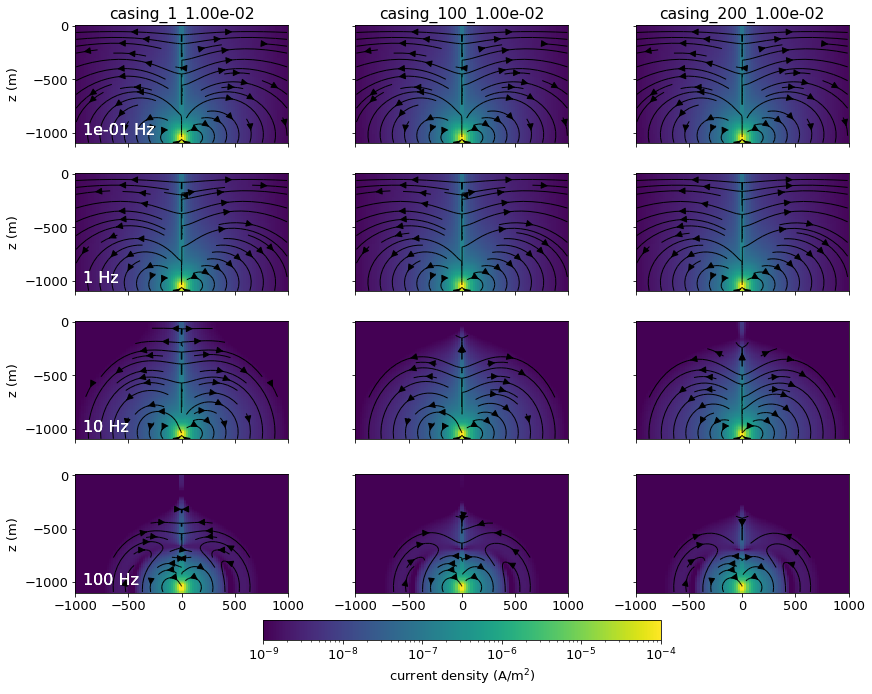

In [59]:
plot_t = 10e-03
plot_mur = np.r_[1, 100, 200]
plot_keys = [f"casing_{mur}_{plot_t:1.2e}" for mur in plot_mur] # ["halfspace", "casing_1", "casing_200"]

fig, ax = plt.subplots(
    len(ind_freq_plot), len(plot_keys), 
    figsize=(4*len(plot_keys), (len(ind_freq_plot))*2.4),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.07,"wspace":0.1}
)

reim = "real" 
xlim= 1000 * np.r_[-1, 1]
zlim=np.r_[-1100, 10]
clim = np.r_[1e-9, 1e-4]
src_ind = 5

stream_opts={"color":"k", "density":0.6, "arrowsize":1.4, "linewidth":1}


for j, key in enumerate(plot_keys):
    f = fields[key]
    
    for i, indf in enumerate(ind_freq_plot): 
        out = casing_sim.view.plot_cross_section(
            f,
            view="j",
            xlim=xlim,
            zlim=zlim,
            theta_ind=0,
            ax=ax[i, j], 
            clim=clim,
            show_cb=False,
            stream_opts=stream_opts,
            real_or_imag=reim,
            src_ind=src_ind*len(frequencies) + indf, 
        )
#         ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        freq = frequencies[indf]
        if freq < 1: 
            ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{freq:1.0e} Hz", color="w", fontsize=16)
        else: 
            ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{freq:1.0f} Hz", color="w", fontsize=16)
        if i < len(frequencies)-1:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_aspect(1)
    ax[0, j].set_title(key)

# ax[0, 0].set_title("(a)\nhalfspace")
# ax[0, 1].set_title("(b)\nconductive casing")
# ax[0, 2].set_title("(c)\nconductive, permeable casing")
cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.6)
cb.set_label("current density (A/m$^2$)")

# if save_figures: 
#     fig.savefig(f"{fig_dir_high}/fdem-cross-section-currents", dpi=dpi_high, bbox_inches="tight")
#     fig.savefig(f"{fig_dir_low}/fdem-cross-section-currents", dpi=dpi_low, bbox_inches="tight")

In [60]:
sigma_casing

5000000.0

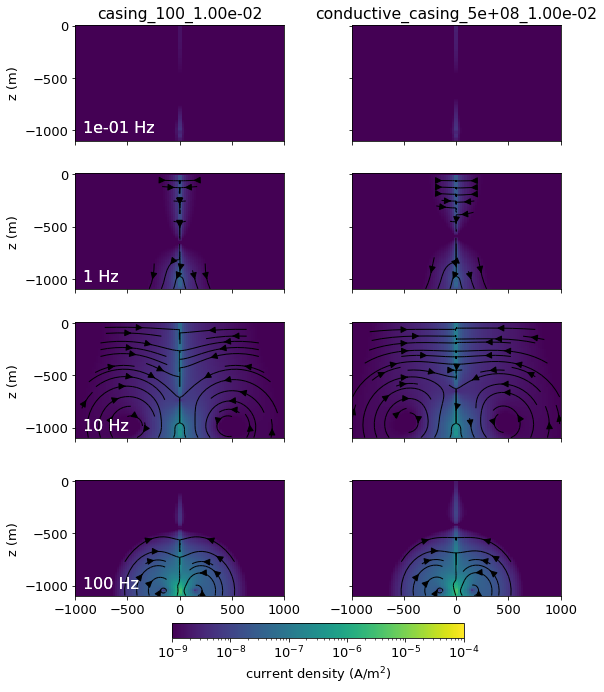

In [63]:
plot_t = 10e-03
plot_mur = 100
plot_keys = [f"casing_{plot_mur}_{plot_t:1.2e}", f"conductive_casing_{plot_mur*sigma_casing:1.0e}_{plot_t:1.2e}"]

fig, ax = plt.subplots(
    len(ind_freq_plot), len(plot_keys), 
    figsize=(4*len(plot_keys), (len(ind_freq_plot))*2.4),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.07,"wspace":0.1}
)

reim = "imag" 
xlim= 1000 * np.r_[-1, 1]
zlim=np.r_[-1100, 10]
clim = np.r_[1e-9, 1e-4]
src_ind = 5

stream_opts={"color":"k", "density":0.6, "arrowsize":1.4, "linewidth":1}


for j, key in enumerate(plot_keys):
    f = fields[key]
    
    for i, indf in enumerate(ind_freq_plot): 
        out = casing_sim.view.plot_cross_section(
            f,
            view="j",
            xlim=xlim,
            zlim=zlim,
            theta_ind=0,
            ax=ax[i, j], 
            clim=clim,
            show_cb=False,
            stream_opts=stream_opts,
            real_or_imag=reim,
            src_ind=src_ind*len(frequencies) + indf, 
        )
#         ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        freq = frequencies[indf]
        if freq < 1: 
            ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{freq:1.0e} Hz", color="w", fontsize=16)
        else: 
            ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{freq:1.0f} Hz", color="w", fontsize=16)
        if i < len(frequencies)-1:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_aspect(1)
    ax[0, j].set_title(key)

# ax[0, 0].set_title("(a)\nhalfspace")
# ax[0, 1].set_title("(b)\nconductive casing")
# ax[0, 2].set_title("(c)\nconductive, permeable casing")
cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.6)
cb.set_label("current density (A/m$^2$)")

# if save_figures: 
#     fig.savefig(f"{fig_dir_high}/fdem-cross-section-currents", dpi=dpi_high, bbox_inches="tight")
#     fig.savefig(f"{fig_dir_low}/fdem-cross-section-currents", dpi=dpi_low, bbox_inches="tight")

In [62]:
len(frequencies)

31

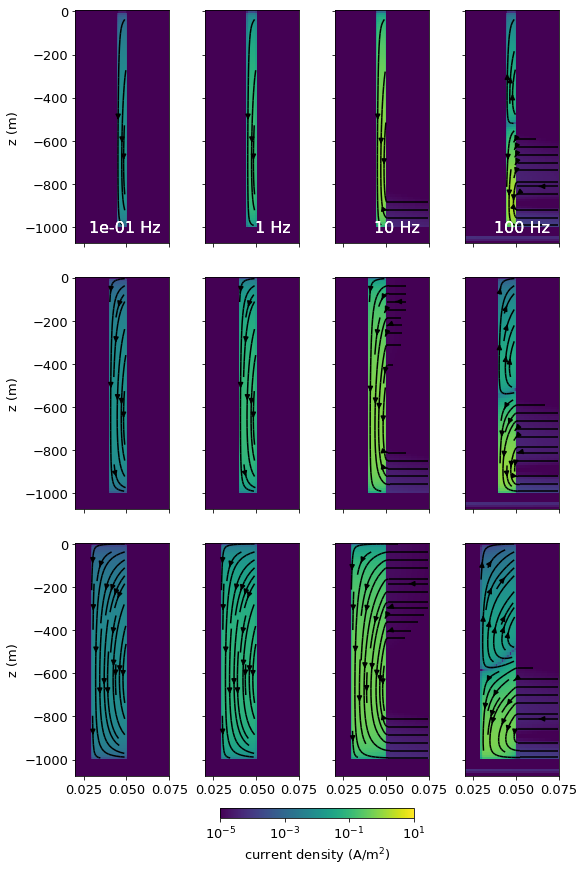

In [64]:
plot_t = np.r_[5e-03, 10e-3, 20e-3]
plot_mur = 1
plot_keys = [f"casing_{plot_mur}_{t:1.2e}" for t in plot_t] # ["halfspace", "casing_1", "casing_200"]

fig, ax = plt.subplots(
    len(plot_keys), len(ind_freq_plot),
    figsize=(len(ind_freq_plot)*2, len(plot_keys)*4),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.09,"wspace":0.05}
)
src_ind = 5
reim = "imag"

xlim= 0.075 * np.r_[0, 1]
zlim=np.r_[-1075, 5]
clim = np.r_[1e-5, 1e1]

# stream_opts={"color":"k", "density":2, "arrowsize":1.4, "linewidth":1.5, "minlength":0.4}


for i, key in enumerate(plot_keys):
    f = fields[key]
    
    for j, indf in enumerate(ind_freq_plot): 
        out = casing_sim.view.plot_cross_section(
            f,
            view="j",
            xlim=xlim,
            zlim=zlim,
            theta_ind=0,
            ax=ax[i, j], 
            clim=clim,
            show_cb=False,
            # stream_opts=stream_opts,
            real_or_imag=reim,
            src_ind=src_ind*len(frequencies) + indf, 
        )
#         ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        freq = frequencies[indf]
        if freq < 1: 
            ax[0, j].text(0.07, zlim.min()+50, f"{freq:1.0e} Hz", color="w", fontsize=16, ha="right")
        else:
            ax[0, j].text(0.07, zlim.min()+50, f"{freq:1.0f} Hz", color="w", fontsize=16, ha="right")
        
        if i < len(frequencies)-1:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_xlim([0.02, 0.075])
        # ax[i, j].set_aspect(1)
    # ax[0, j].set_title(key)
cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.4)
cb.set_label("current density (A/m$^2$)")


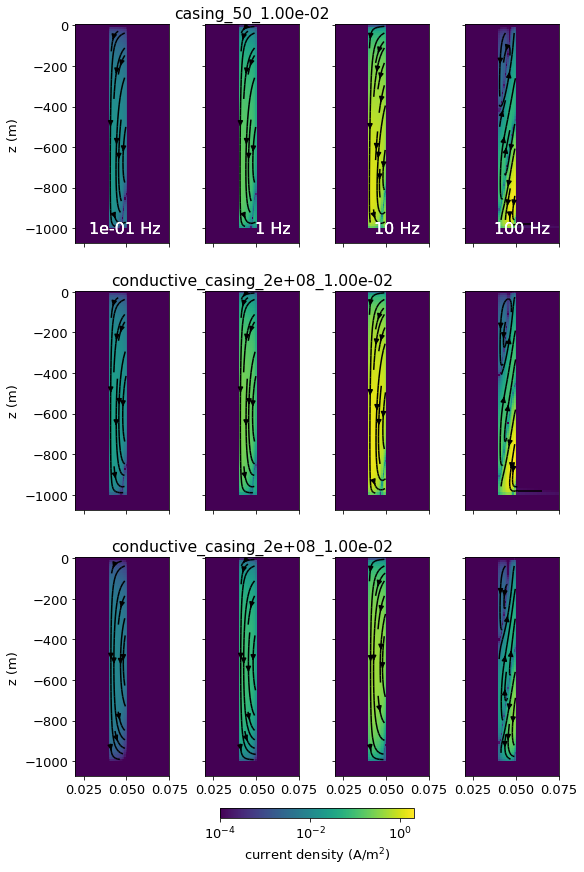

In [67]:
plot_t = 10e-03
plot_mur = 50
plot_keys = [f"casing_{plot_mur}_{plot_t:1.2e}", f"conductive_casing_{plot_mur*sigma_casing:1.0e}_{plot_t:1.2e}"]
fig, ax = plt.subplots(
    len(plot_keys)+1, len(ind_freq_plot),
    figsize=(len(ind_freq_plot)*2, (len(plot_keys)+1)*4),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.09,"wspace":0.05}
)
src_ind = 5
reim = "imag"

xlim= 0.075 * np.r_[0, 1]
zlim=np.r_[-1075, 5]
clim = np.r_[1e-4, 2]

# stream_opts={"color":"k", "density":2, "arrowsize":1.4, "linewidth":1.5, "minlength":0.4}

for i in range(len(plot_keys)+1):
    if i < len(plot_keys):
        key = plot_keys[i]
        primsec = "total"
    else:
        key = plot_keys[-1]
        primsec = "secondary"
    for j, indf in enumerate(ind_freq_plot): 
        out = casing_sim.view.plot_cross_section(
            fields[key],
            view="j",
            xlim=xlim,
            zlim=zlim,
            theta_ind=0,
            ax=ax[i, j], 
            clim=clim,
            show_cb=False,
            primary_fields=fields[plot_keys[0]], 
            prim_sec=primsec,
            # stream_opts=stream_opts,
            real_or_imag=reim,
            src_ind=src_ind*len(frequencies) + indf, 
        )
#         ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        freq = frequencies[indf]
        if freq < 1: 
            ax[0, j].text(0.07, zlim.min()+50, f"{freq:1.0e} Hz", color="w", fontsize=16, ha="right")
        else:
            ax[0, j].text(0.07, zlim.min()+50, f"{freq:1.0f} Hz", color="w", fontsize=16, ha="right")
        
        if i < len(frequencies)-1:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_xlim([0.02, 0.075])
        # ax[i, j].set_aspect(1)
    ax[i, 1].set_title(key)
cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.4)
cb.set_label("current density (A/m$^2$)")


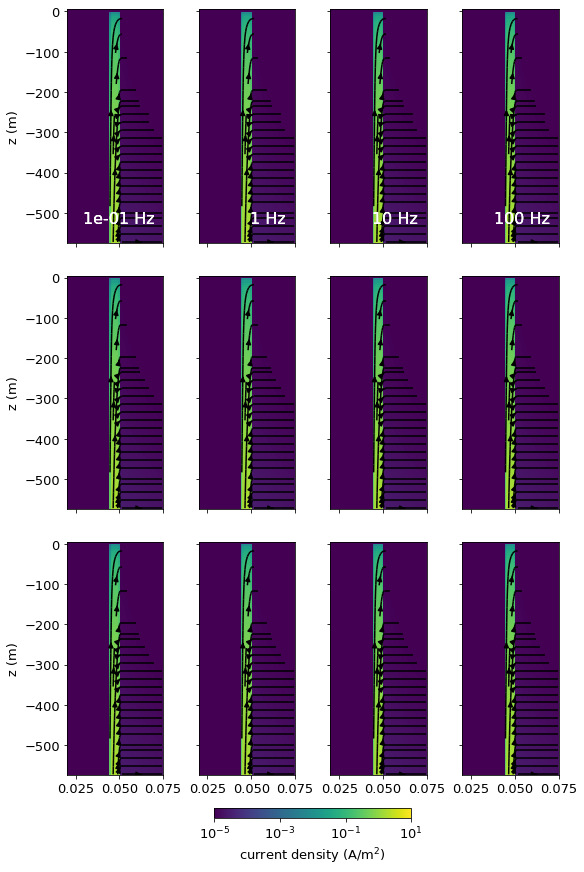

In [68]:
plot_t = 5e-03
plot_mur = np.r_[1, 100, 200]
plot_keys = [f"casing_{mur}_{plot_t:1.2e}" for mur in plot_mur] # ["halfspace", "casing_1", "casing_200"]

fig, ax = plt.subplots(
    len(plot_keys), len(ind_freq_plot),
    figsize=(len(ind_freq_plot)*2, len(plot_keys)*4),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.09,"wspace":0.05}
)
src_ind = 5
reim = "real"

xlim= 0.075 * np.r_[0, 1]
zlim=np.r_[-575, 5]
clim = np.r_[1e-5, 1e1]

# stream_opts={"color":"k", "density":2, "arrowsize":1.4, "linewidth":1.5, "minlength":0.4}


for i, key in enumerate(plot_keys):
    f = fields[key]
    
    for j, indf in enumerate(ind_freq_plot): 
        out = casing_sim.view.plot_cross_section(
            f,
            view="j",
            xlim=xlim,
            zlim=zlim,
            theta_ind=0,
            ax=ax[i, j], 
            clim=clim,
            show_cb=False,
            # stream_opts=stream_opts,
            real_or_imag=reim,
            src_ind=src_ind*len(frequencies) + i, 
        )
#         ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        freq = frequencies[indf]
        if freq < 1: 
            ax[0, j].text(0.07, zlim.min()+50, f"{freq:1.0e} Hz", color="w", fontsize=16, ha="right")
        else:
            ax[0, j].text(0.07, zlim.min()+50, f"{freq:1.0f} Hz", color="w", fontsize=16, ha="right")
        
        if i < len(frequencies)-1:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_xlim([0.02, 0.075])
        # ax[i, j].set_aspect(1)
    # ax[0, j].set_title(key)
cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.4)
cb.set_label("current density (A/m$^2$)")


In [69]:
def plot_pos_neg_log(x, y, ax, plot_type="semilogy", ls=None, color=None, marker=None, label=None):
    if plot_type == "plot":
        return ax.plot(x, y, color=color, label=label)
    else:
        inds_pos = (y > 0)
        
        inds_switch = np.where(np.diff(inds_pos))[0].astype(int)+1
        starting_inds = np.hstack([np.r_[0], inds_switch])
        ending_inds = np.hstack([inds_switch, np.r_[len(inds_pos)]])
        
        if ls is None:
            pos_ls = "-"
            neg_ls = "--"
        else:
            pos_ls = "-."
            neg_ls = ":"
            
        for start, end in zip(starting_inds, ending_inds):
            xvals = x[start:end]
            yvals = y[start:end]
            if np.all(yvals <= 0):
                getattr(ax, plot_type)(xvals, np.abs(yvals), neg_ls, marker=marker, color=color)
            else: 
                getattr(ax, plot_type)(xvals, yvals, pos_ls, marker=marker, color=color, label=label)
                label=None
        return ax

In [70]:
fields.keys()

dict_keys(['halfspace', 'casing_1_5.00e-03', 'casing_50_5.00e-03', 'casing_100_5.00e-03', 'casing_150_5.00e-03', 'casing_200_5.00e-03', 'casing_1_7.50e-03', 'casing_50_7.50e-03', 'casing_100_7.50e-03', 'casing_150_7.50e-03', 'casing_200_7.50e-03', 'casing_1_1.00e-02', 'casing_50_1.00e-02', 'casing_100_1.00e-02', 'casing_150_1.00e-02', 'casing_200_1.00e-02', 'casing_1_1.25e-02', 'casing_50_1.25e-02', 'casing_100_1.25e-02', 'casing_150_1.25e-02', 'casing_200_1.25e-02', 'casing_1_1.50e-02', 'casing_50_1.50e-02', 'casing_100_1.50e-02', 'casing_150_1.50e-02', 'casing_200_1.50e-02', 'casing_1_2.00e-02', 'casing_50_2.00e-02', 'casing_100_2.00e-02', 'casing_150_2.00e-02', 'casing_200_2.00e-02', 'conductive_casing_5e+06_5.00e-03', 'conductive_casing_2e+08_5.00e-03', 'conductive_casing_5e+08_5.00e-03', 'conductive_casing_8e+08_5.00e-03', 'conductive_casing_1e+09_5.00e-03', 'conductive_casing_5e+06_7.50e-03', 'conductive_casing_2e+08_7.50e-03', 'conductive_casing_5e+08_7.50e-03', 'conductive_casi

In [71]:
xlocs = np.r_[79]
mesh.nodes_x[xlocs]

array([100.])

In [72]:
zloc = -csz/2

face_ind = np.where(
    (mesh.faces_x[:, 0] == mesh.vectorNx[xlocs[0]]) &
    (np.abs(mesh.faces_x[:, 2] - zloc) == np.min(np.abs(mesh.faces_x[:, 2] - zloc)))
)[0][0]
print(mesh.faces_x[face_ind, :])

[100.     0.    -1.25]


/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.vectorNx has been deprecated, please use CylindricalMesh.nodes_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


In [73]:
def get_amplitude_phase(f):
    real = f.real
    imag = f.imag
    amplitude = np.sqrt(real**2 + imag**2)
    phase = 180/np.pi*np.arctan2(imag, real)
    return amplitude, phase

# Plot as a function of frequency

In [87]:
skin_depth

<function __main__.skin_depth(f, sigma, mur)>

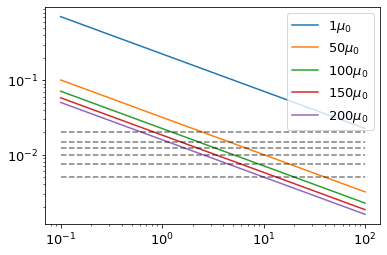

In [96]:
fig, ax = plt.subplots(1, 1)

for mur in mur_casing:
    ax.loglog(frequencies, skin_depth(frequencies, sigma_casing, mur), label=f"{mur}$\mu_0$") 

for t in casing_t:
    ax.loglog(frequencies, t*np.ones_like(frequencies), "--", alpha=0.5, color="k")
ax.legend()

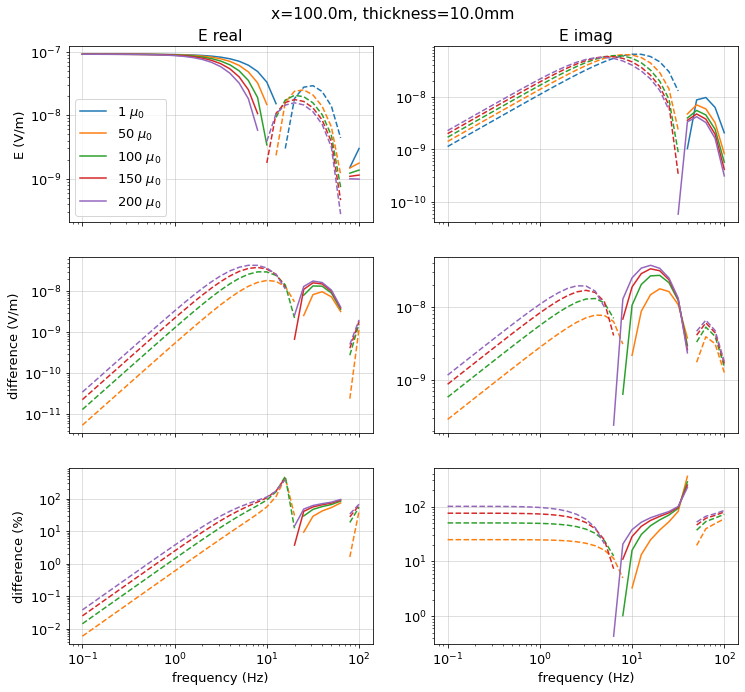

In [74]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

src_ind = 5
t_plot = 10e-3
primary_key = f"casing_1_{t_plot:1.2e}"
mur_plot = mur_casing
inds_src = slice(src_ind*len(frequencies), (src_ind+1)*len(frequencies))

primary = fields[primary_key][:, "e"][face_ind][inds_src]

re_ylim = 1e-5*np.r_[-1, 12]
im_ylim = 1e-6*np.r_[-1, 30]

for i, key in enumerate([f"casing_{mur}_{t_plot:1.2e}" for mur in mur_casing]):
    total = fields[key][:, "e"][face_ind][inds_src]
    diff = total - primary
    
    label = f"{key.split('_')[-2]} $\mu_0$"
    plot_pos_neg_log(frequencies, total.real, ax[0, 0], plot_type="loglog", color=f"C{i}", label=label)
    plot_pos_neg_log(frequencies, total.imag, ax[0, 1], plot_type="loglog", color=f"C{i}", label=label)
    
    plot_pos_neg_log(frequencies, diff.real, ax[1, 0], plot_type="loglog", color=f"C{i}", label=None)
    plot_pos_neg_log(frequencies, diff.imag, ax[1, 1], plot_type="loglog", color=f"C{i}", label=None)
    
    plot_pos_neg_log(frequencies, diff.real/np.abs(primary.real)*100, ax[2, 0], plot_type="loglog", color=f"C{i}", label=None)
    plot_pos_neg_log(frequencies, diff.imag/np.abs(primary.imag)*100, ax[2, 1], plot_type="loglog", color=f"C{i}", label=None)
    
for a in ax.flatten():
    a.grid("both", alpha=0.5)

ax[0, 0].set_title("E real")
ax[0, 1].set_title("E imag")
fig.suptitle(f"x={mesh.faces_x[face_ind, 0]}m, thickness={t_plot*1e3:1.1f}mm", y=0.93)

ax[0, 0].set_ylabel("E (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[2, 0].set_ylabel("difference (%)")
ax[2, 0].set_xlabel("frequency (Hz)")
ax[2, 1].set_xlabel("frequency (Hz)")
    
ax[0, 0].legend(loc=0)

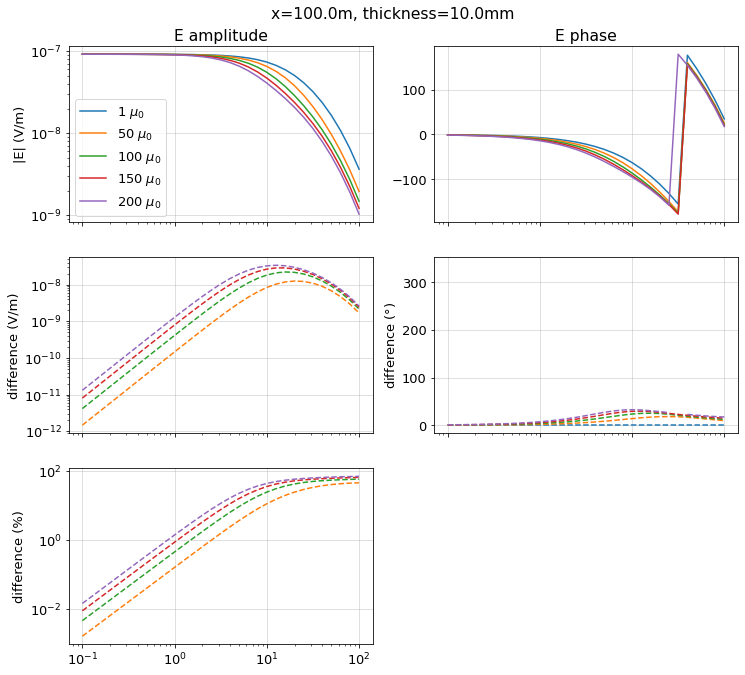

In [75]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

src_ind = 5
t_plot = 10e-3
primary_key = f"casing_1_{t_plot:1.2e}"
mur_plot = mur_casing
inds_src = slice(src_ind*len(frequencies), (src_ind+1)*len(frequencies))

primary = fields[primary_key][:, "e"][face_ind][inds_src]
a_primary, p_primary = get_amplitude_phase(primary)

re_ylim = 1e-5*np.r_[-1, 12]
im_ylim = 1e-6*np.r_[-1, 30]

for i, key in enumerate([f"casing_{mur}_{t_plot:1.2e}" for mur in mur_casing]):
    total = fields[key][:, "e"][face_ind][inds_src]
    a_total, p_total = get_amplitude_phase(total) 
    
    a_diff = a_total - a_primary
    p_diff = p_total - p_primary
    
    label = f"{key.split('_')[-2]} $\mu_0$"
    ax[0, 0].loglog(frequencies, a_total, color=f"C{i}", label=label)
    ax[0, 1].semilogx(frequencies, p_total, color=f"C{i}", label=label)
    
    plot_pos_neg_log(frequencies, a_diff, ax[1, 0], plot_type="loglog", color=f"C{i}", label=None)
    plot_pos_neg_log(frequencies, p_diff, ax[1, 1], plot_type="semilogx", color=f"C{i}", label=None)
    
    plot_pos_neg_log(frequencies, a_diff/np.abs(a_primary)*100, ax[2, 0], plot_type="loglog", color=f"C{i}", label=None)
    
for a in ax.flatten():
    a.grid("both", alpha=0.5)
ax[2, 1].axis("off")

ax[0, 0].set_title("E amplitude")
ax[0, 1].set_title("E phase")
fig.suptitle(f"x={mesh.faces_x[face_ind, 0]}m, thickness={t_plot*1e3:1.1f}mm", y=0.93)

ax[0, 0].set_ylabel("|E| (V/m)")
# ax[0, 1].set_ylabel("phase(E) ($\degree$)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[1, 1].set_ylabel("difference ($\degree$)")
ax[2, 0].set_ylabel("difference (%)")

ax[0, 0].legend(loc=0)

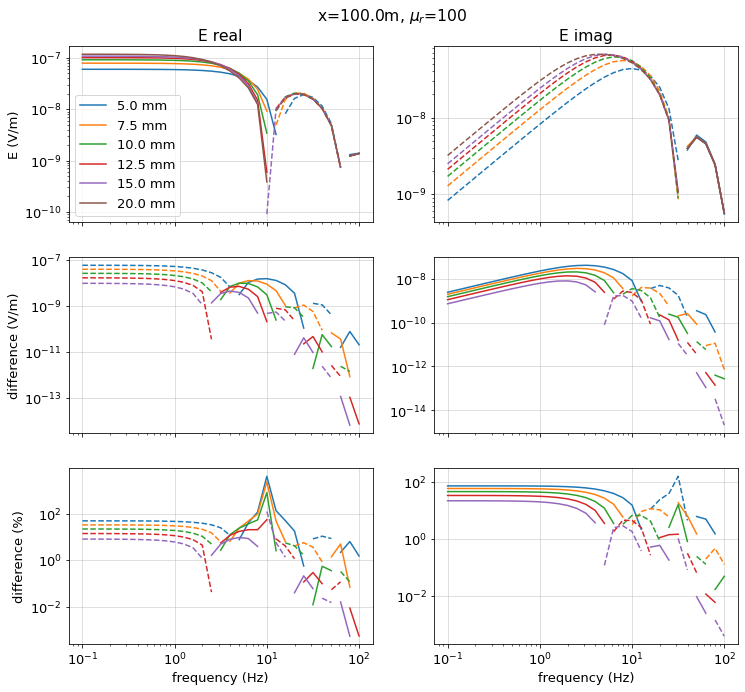

In [76]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

src_ind = 5
reference_t = casing_t.max()
mur_plot = 100 
casing_t_plot = casing_t # np.r_[5e-3, 1e-2, 1.5e-2, 2e-2]

primary_key = f"casing_{mur_plot}_{reference_t:1.2e}"
inds_src = slice(src_ind*len(frequencies), (src_ind+1)*len(frequencies))

primary = fields[primary_key][:, "e"][face_ind][inds_src]

re_ylim = 1e-5*np.r_[-1, 12]
im_ylim = 1e-6*np.r_[-1, 30]

for i, key in enumerate([f"casing_{mur_plot}_{t:1.2e}" for t in casing_t_plot]):
    total = fields[key][:, "e"][face_ind][inds_src]
    diff = total - primary
    
    label = f"{float(key.split('_')[-1])*1e3:1.1f} mm"
    plot_pos_neg_log(frequencies, total.real, ax[0, 0], plot_type="loglog", color=f"C{i}", label=label)
    plot_pos_neg_log(frequencies, total.imag, ax[0, 1], plot_type="loglog", color=f"C{i}", label=label)
    
    plot_pos_neg_log(frequencies, diff.real, ax[1, 0], plot_type="loglog", color=f"C{i}", label=None)
    plot_pos_neg_log(frequencies, diff.imag, ax[1, 1], plot_type="loglog", color=f"C{i}", label=None)
    
    plot_pos_neg_log(frequencies, diff.real/np.abs(primary.real)*100, ax[2, 0], plot_type="loglog", color=f"C{i}", label=None)
    plot_pos_neg_log(frequencies, diff.imag/np.abs(primary.imag)*100, ax[2, 1], plot_type="loglog", color=f"C{i}", label=None)
    
for a in ax.flatten():
    a.grid("both", alpha=0.5)

ax[0, 0].set_title("E real")
ax[0, 1].set_title("E imag")
fig.suptitle(f"x={mesh.faces_x[face_ind, 0]}m, $\mu_r$={mur_plot:1.0f}", y=0.93)

ax[0, 0].set_ylabel("E (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[2, 0].set_ylabel("difference (%)")
ax[2, 0].set_xlabel("frequency (Hz)")
ax[2, 1].set_xlabel("frequency (Hz)")
    
ax[0, 0].legend(loc=0)

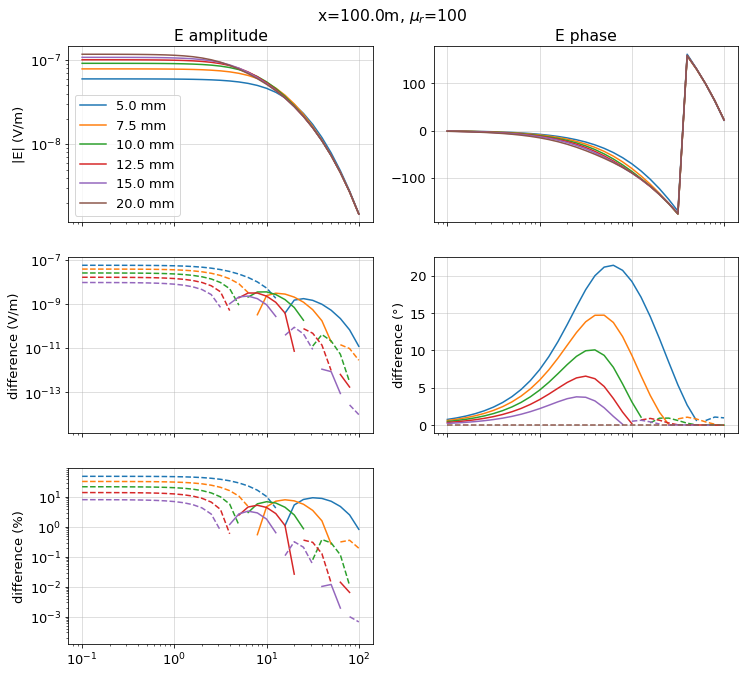

In [77]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

src_ind = 5
reference_t = casing_t.max()
mur_plot = 100 
casing_t_plot = casing_t # np.r_[5e-3, 1e-2, 1.5e-2, 2e-2]

primary_key = f"casing_{mur_plot}_{reference_t:1.2e}"
inds_src = slice(src_ind*len(frequencies), (src_ind+1)*len(frequencies))

primary = fields[primary_key][:, "e"][face_ind][inds_src]
a_primary, p_primary = get_amplitude_phase(primary)

re_ylim = 1e-5*np.r_[-1, 12]
im_ylim = 1e-6*np.r_[-1, 30]

for i, key in enumerate([f"casing_{mur_plot}_{t:1.2e}" for t in casing_t_plot]):
    total = fields[key][:, "e"][face_ind][inds_src]
    a_total, p_total = get_amplitude_phase(total) 
    
    a_diff = a_total - a_primary
    p_diff = p_total - p_primary
    
    label = f"{float(key.split('_')[-1])*1e3:1.1f} mm"
    ax[0, 0].loglog(frequencies, a_total, color=f"C{i}", label=label)
    ax[0, 1].semilogx(frequencies, p_total, color=f"C{i}", label=label)
    
    plot_pos_neg_log(frequencies, a_diff, ax[1, 0], plot_type="loglog", color=f"C{i}", label=None)
    plot_pos_neg_log(frequencies, p_diff, ax[1, 1], plot_type="semilogx", color=f"C{i}", label=None)
    
    plot_pos_neg_log(frequencies, a_diff/a_primary*100, ax[2, 0], plot_type="loglog", color=f"C{i}", label=None)
    
for a in ax.flatten():
    a.grid("both", alpha=0.5)
ax[2, 1].axis("off")

ax[0, 0].set_title("E amplitude")
ax[0, 1].set_title("E phase")
fig.suptitle(f"x={mesh.faces_x[face_ind, 0]}m, $\mu_r$={mur_plot:1.0f}", y=0.93)

ax[0, 0].set_ylabel("|E| (V/m)")
# ax[0, 1].set_ylabel("phase(E) ($\degree$)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[1, 1].set_ylabel("difference ($\degree$)")
ax[2, 0].set_ylabel("difference (%)")

ax[0, 0].legend(loc=0)

## preserve conductivity thickness product 

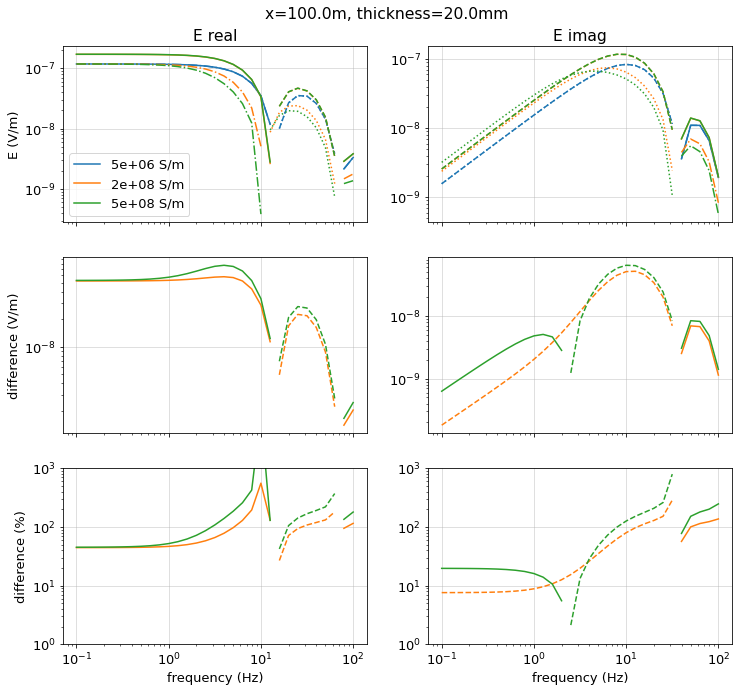

In [78]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

src_ind = 5
t_plot = 20e-3


mur_plot = mur_casing
inds_src = slice(src_ind*len(frequencies), (src_ind+1)*len(frequencies))

re_ylim = 1e-5*np.r_[-1, 12]
im_ylim = 1e-6*np.r_[-1, 30]

for i, mur in enumerate(mur_casing[:-2]): 
    primary_key = f"casing_{mur}_{t_plot:1.2e}" 
    key = f"conductive_casing_{sigma_casing*mur:1.0e}_{t_plot:1.2e}"

    primary = fields[primary_key][:, "e"][face_ind][inds_src]
    total = fields[key][:, "e"][face_ind][inds_src]
    diff = total - primary

    label = f"{mur*sigma_casing:1.0e} S/m"
    plot_pos_neg_log(frequencies, total.real, ax[0, 0], plot_type="loglog", color=f"C{i}", label=label)
    plot_pos_neg_log(frequencies, total.imag, ax[0, 1], plot_type="loglog", color=f"C{i}", label=label)
    plot_pos_neg_log(frequencies, primary.real, ax[0, 0], plot_type="loglog", color=f"C{i}", ls="alternate")
    plot_pos_neg_log(frequencies, primary.imag, ax[0, 1], plot_type="loglog", color=f"C{i}", ls="alternate")

    plot_pos_neg_log(frequencies, diff.real, ax[1, 0], plot_type="loglog", color=f"C{i}", label=None)
    plot_pos_neg_log(frequencies, diff.imag, ax[1, 1], plot_type="loglog", color=f"C{i}", label=None)

    plot_pos_neg_log(frequencies, diff.real/np.abs(primary.real)*100, ax[2, 0], plot_type="loglog", color=f"C{i}", label=None)
    plot_pos_neg_log(frequencies, diff.imag/np.abs(primary.imag)*100, ax[2, 1], plot_type="loglog", color=f"C{i}", label=None)

for a in ax.flatten():
    a.grid("both", alpha=0.5)

ax[0, 0].set_title("E real")
ax[0, 1].set_title("E imag")
fig.suptitle(f"x={mesh.faces_x[face_ind, 0]}m, thickness={t_plot*1e3:1.1f}mm", y=0.93)

ax[0, 0].set_ylabel("E (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[2, 0].set_ylabel("difference (%)")
ax[2, 0].set_xlabel("frequency (Hz)")
ax[2, 1].set_xlabel("frequency (Hz)")

for a in ax[2, :]:
    a.set_ylim(1, 1e3)
    
ax[0, 0].legend(loc=0)

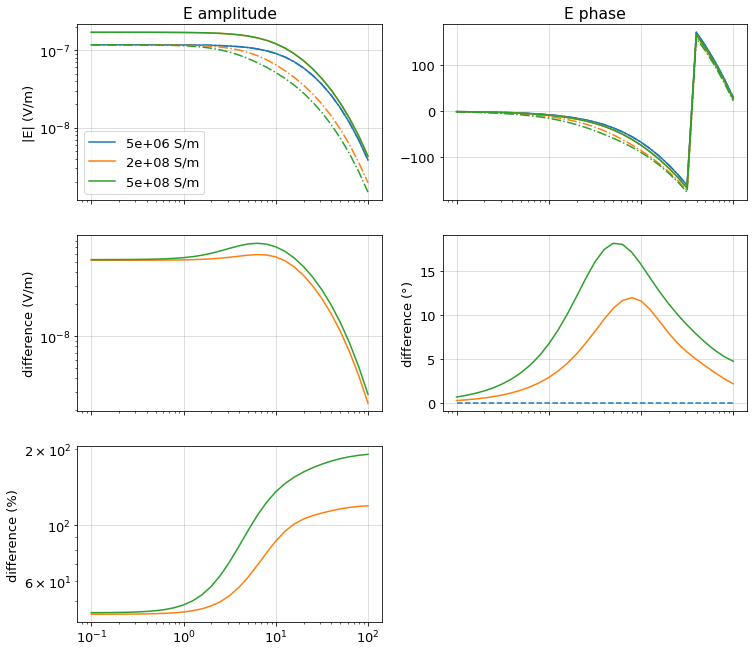

In [79]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

src_ind = 5
t_plot = 20e-3


mur_plot = mur_casing
inds_src = slice(src_ind*len(frequencies), (src_ind+1)*len(frequencies))

re_ylim = 1e-5*np.r_[-1, 12]
im_ylim = 1e-6*np.r_[-1, 30]

for i, mur in enumerate(mur_casing[:-2]): 
    primary_key = f"casing_{mur}_{t_plot:1.2e}" 
    key = f"conductive_casing_{sigma_casing*mur:1.0e}_{t_plot:1.2e}"

    primary = fields[primary_key][:, "e"][face_ind][inds_src]
    a_primary, p_primary = get_amplitude_phase(primary) 

    label = f"{mur*sigma_casing:1.0e} S/m"
    total = fields[key][:, "e"][face_ind][inds_src]
    a_total, p_total = get_amplitude_phase(total) 
    
    a_diff = a_total - a_primary
    p_diff = p_total - p_primary
    
    ax[0, 0].loglog(frequencies, a_total, color=f"C{i}", label=label)
    ax[0, 1].semilogx(frequencies, p_total, color=f"C{i}", label=label)
    
    ax[0, 0].loglog(frequencies, a_primary, color=f"C{i}", ls="-.")
    ax[0, 1].semilogx(frequencies, p_primary, color=f"C{i}", ls="-.")
    
    plot_pos_neg_log(frequencies, a_diff, ax[1, 0], plot_type="loglog", color=f"C{i}", label=None)
    plot_pos_neg_log(frequencies, p_diff, ax[1, 1], plot_type="semilogx", color=f"C{i}", label=None)
    
    plot_pos_neg_log(frequencies, a_diff/a_primary*100, ax[2, 0], plot_type="loglog", color=f"C{i}", label=None)
    
for a in ax.flatten():
    a.grid("both", alpha=0.5)
ax[2, 1].axis("off")

ax[0, 0].set_title("E amplitude")
ax[0, 1].set_title("E phase")
# fig.suptitle(f"x={mesh.faces_x[face_ind, 0]}m, $\mu_r$={mur_plot:1.0f}", y=0.93)

ax[0, 0].set_ylabel("|E| (V/m)")
# ax[0, 1].set_ylabel("phase(E) ($\degree$)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[1, 1].set_ylabel("difference ($\degree$)")
ax[2, 0].set_ylabel("difference (%)")

ax[0, 0].legend(loc=0)

# Plot as a function of x

In [80]:
zloc = -csz/2
faces_perpendicular = np.where(
    (np.abs(mesh.faces_x[:, 2] - zloc) == np.min(np.abs(mesh.faces_x[:, 2] - zloc)))
)[0]

In [81]:
frequencies[10]

1.0

10.0


Text(0.5, 0, 'x (m)')

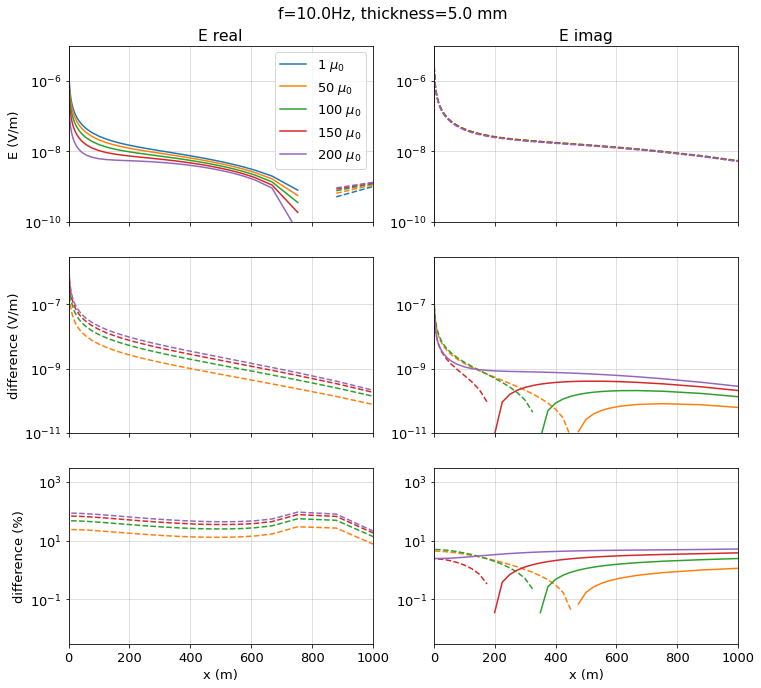

In [82]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

mur_plot = 100
freq_ind = 20
src_ind = 5

print(frequencies[freq_ind])

t_plot = 5e-3
mur_plot = mur_casing
primary_key = f"casing_1_{t_plot:1.2e}"

src_ind = src_ind*len(frequencies) + freq_ind
primary_src = fields[primary_key].survey.source_list[src_ind]
primary = fields[primary_key][primary_src, "e"][faces_perpendicular].squeeze()

for i, key in enumerate([f"casing_{mur}_{t_plot:1.2e}" for mur in mur_casing]):
    src = fields[key].survey.source_list[src_ind]
    total = fields[key][src, "e"][faces_perpendicular].squeeze()
    diff = total - primary
    
    label = f"{key.split('_')[-2]} $\mu_0$"
    
    plot_pos_neg_log(mesh.nodes_x, total.real, ax[0, 0], plot_type="semilogy", color=f"C{i}", label=label)
    plot_pos_neg_log(mesh.nodes_x, total.imag, ax[0, 1], plot_type="semilogy", color=f"C{i}", label=label)
    
    plot_pos_neg_log(mesh.nodes_x, diff.real, ax[1, 0], plot_type="semilogy", color=f"C{i}")
    plot_pos_neg_log(mesh.nodes_x, diff.imag, ax[1, 1], plot_type="semilogy", color=f"C{i}")
    
    plot_pos_neg_log(mesh.nodes_x, diff.real/np.abs(primary.real)*100, ax[2, 0], plot_type="semilogy", color=f"C{i}")
    plot_pos_neg_log(mesh.nodes_x, diff.imag/np.abs(primary.imag)*100, ax[2, 1], plot_type="semilogy", color=f"C{i}")
 
ax[0, 0].set_xlim([0, 1000])
ax[0, 0].legend()

for a in ax.flatten():
    a.grid("both", alpha=0.5)

for a in ax[0, :].flatten():
    a.set_ylim([1e-10, 1e-5])
    
for a in ax[1, :].flatten():
    a.set_ylim([1e-11, 3e-6])

for a in ax[2, :].flatten():
    a.set_ylim([3e-3, 3e3])

ax[0, 0].set_title("E real")
ax[0, 1].set_title("E imag")
fig.suptitle(f"f={frequencies[freq_ind]}Hz, thickness={t_plot*1e3:1.1f} mm", y=0.93)

ax[0, 0].set_ylabel("E (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[2, 0].set_ylabel("difference (%)")
ax[2, 0].set_xlabel("x (m)")
ax[2, 1].set_xlabel("x (m)")

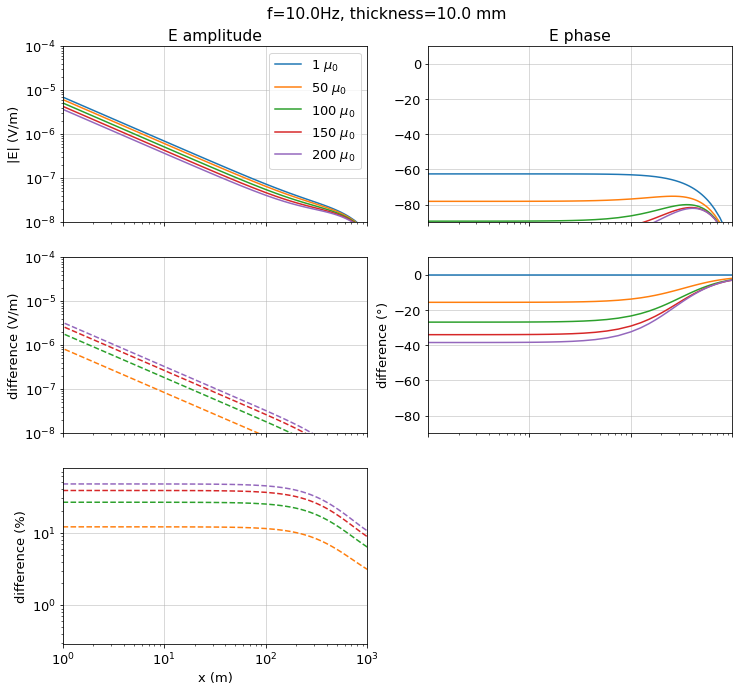

In [83]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

mur_plot = 100
freq_ind = 20
src_ind = 5

t_plot = 10e-3
mur_plot = mur_casing
primary_key = f"casing_1_{t_plot:1.2e}"

src_ind = src_ind*len(frequencies) + freq_ind
primary_src = fields[primary_key].survey.source_list[src_ind]
primary = fields[primary_key][primary_src, "e"][faces_perpendicular].squeeze()
a_primary, p_primary = get_amplitude_phase(primary)

for i, key in enumerate([f"casing_{mur}_{t_plot:1.2e}" for mur in mur_casing]):
    src = fields[key].survey.source_list[src_ind]
    total = fields[key][src, "e"][faces_perpendicular].squeeze()
    a_total, p_total = get_amplitude_phase(total) 
    a_diff = a_total - a_primary
    p_diff = p_total - p_primary
    
    label = f"{key.split('_')[-2]} $\mu_0$"
    
    ax[0, 0].loglog(mesh.nodes_x[1:], a_total[1:], color=f"C{i}", label=label)
    ax[0, 1].plot(mesh.nodes_x[1:], p_total[1:], color=f"C{i}", label=label)
    
    plot_pos_neg_log(mesh.nodes_x[1:], a_diff[1:], ax[1, 0], plot_type="semilogy", color=f"C{i}", label=None)
    ax[1, 1].plot(mesh.nodes_x[1:], p_diff[1:], color=f"C{i}")
    
    plot_pos_neg_log(mesh.nodes_x[1:], a_diff[1:]/a_primary[1:]*100, ax[2, 0], plot_type="semilogy", color=f"C{i}", label=None)
 
ax[0, 0].set_xlim([1e0, 1e3])
ax[0, 0].legend()

for a in ax.flatten():
    a.grid("both", alpha=0.6)

for a in ax[:2, 0]:
    a.set_ylim(1e-8, 1e-4)
for a in ax[:2, 1]:
    a.set_ylim(-90, 10)


ax[0, 0].set_title("E amplitude")
ax[0, 1].set_title("E phase")
fig.suptitle(f"f={frequencies[freq_ind]}Hz, thickness={t_plot*1e3:1.1f} mm", y=0.93)

ax[0, 0].set_ylabel("|E| (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[1, 1].set_ylabel("difference ($\degree$)")
ax[2, 0].set_ylabel("difference (%)")
ax[2, 0].set_xlabel("x (m)")
ax[2, 1].axis("off");

Text(0.5, 0, 'x (m)')

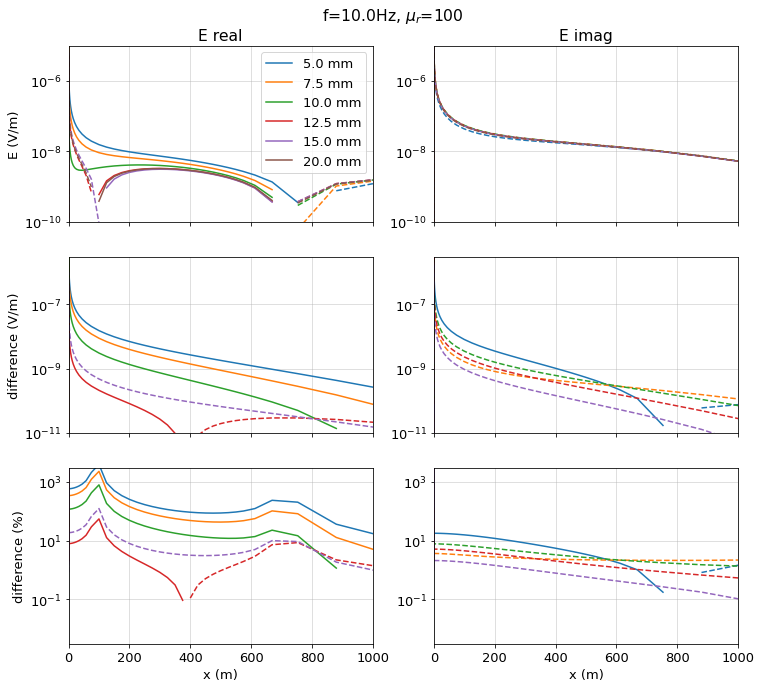

In [85]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

mur_plot = 100
freq_ind = 20
src_ind = 5

reference_t = casing_t.max()
casing_t_plot = casing_t # np.r_[5e-3, 1e-2, 1.5e-2, 2e-2]

primary_key = f"casing_{mur_plot}_{reference_t:1.2e}"

src_ind = src_ind*len(frequencies) + freq_ind
primary_src = fields[primary_key].survey.source_list[src_ind]
primary = fields[primary_key][primary_src, "e"][faces_perpendicular].squeeze()

for i, key in enumerate([f"casing_{mur_plot}_{t:1.2e}" for t in casing_t_plot]):
    src = fields[key].survey.source_list[src_ind]
    total = fields[key][src, "e"][faces_perpendicular].squeeze()
    diff = total - primary
    
    label = f"{float(key.split('_')[-1])*1e3:1.1f} mm"
    
    plot_pos_neg_log(mesh.nodes_x, total.real, ax[0, 0], plot_type="semilogy", color=f"C{i}", label=label)
    plot_pos_neg_log(mesh.nodes_x, total.imag, ax[0, 1], plot_type="semilogy", color=f"C{i}", label=label)
    
    plot_pos_neg_log(mesh.nodes_x, diff.real, ax[1, 0], plot_type="semilogy", color=f"C{i}")
    plot_pos_neg_log(mesh.nodes_x, diff.imag, ax[1, 1], plot_type="semilogy", color=f"C{i}")
    
    plot_pos_neg_log(mesh.nodes_x, diff.real/np.abs(primary.real)*100, ax[2, 0], plot_type="semilogy", color=f"C{i}")
    plot_pos_neg_log(mesh.nodes_x, diff.imag/np.abs(primary.imag)*100, ax[2, 1], plot_type="semilogy", color=f"C{i}")
 
ax[0, 0].set_xlim([0, 1000])
ax[0, 0].legend()

for a in ax.flatten():
    a.grid("both", alpha=0.5)

for a in ax[0, :].flatten():
    a.set_ylim([1e-10, 1e-5])
    
for a in ax[1, :].flatten():
    a.set_ylim([1e-11, 3e-6])

for a in ax[2, :].flatten():
    a.set_ylim([3e-3, 3e3])
    

ax[0, 0].set_title("E real")
ax[0, 1].set_title("E imag")
fig.suptitle(f"f={frequencies[freq_ind]}Hz, $\mu_r$={mur_plot:1.0f}", y=0.93)

ax[0, 0].set_ylabel("E (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[2, 0].set_ylabel("difference (%)")
ax[2, 0].set_xlabel("x (m)")
ax[2, 1].set_xlabel("x (m)")

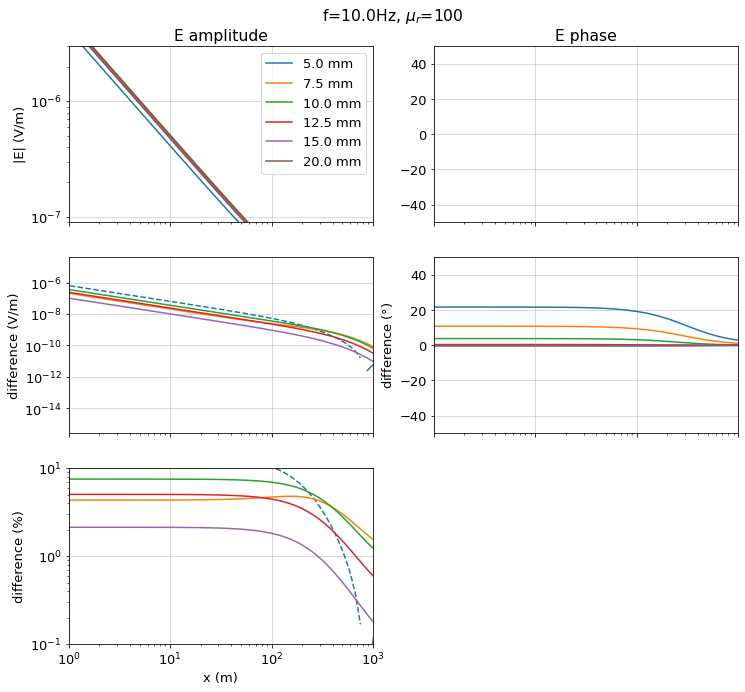

In [86]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

mur_plot = 100
freq_ind = 20
src_ind = 5

reference_t = casing_t.max()
casing_t_plot = casing_t # np.r_[5e-3, 1e-2, 1.5e-2, 2e-2]

primary_key = f"casing_{mur_plot}_{reference_t:1.2e}"

src_ind = src_ind*len(frequencies) + freq_ind
primary_src = fields[primary_key].survey.source_list[src_ind]
primary = fields[primary_key][primary_src, "e"][faces_perpendicular].squeeze()

a_primary, p_primary = get_amplitude_phase(primary)

for i, key in enumerate([f"casing_{mur_plot}_{t:1.2e}" for t in casing_t_plot]):
    src = fields[key].survey.source_list[src_ind]
    total = fields[key][src, "e"][faces_perpendicular].squeeze()
    a_total, p_total = get_amplitude_phase(total) 
    a_diff = a_total - a_primary
    p_diff = p_total - p_primary
    
    label = f"{float(key.split('_')[-1])*1e3:1.1f} mm"
    
    ax[0, 0].loglog(mesh.nodes_x[1:], a_total[1:], color=f"C{i}", label=label)
    ax[0, 1].plot(mesh.nodes_x[1:], p_total[1:], color=f"C{i}", label=label)
    
    plot_pos_neg_log(mesh.nodes_x[1:], a_diff[1:], ax[1, 0], plot_type="semilogy", color=f"C{i}", label=None)
    ax[1, 1].plot(mesh.nodes_x[1:], p_diff[1:], color=f"C{i}")
    
    plot_pos_neg_log(mesh.nodes_x[1:], a_diff[1:]/a_primary[1:]*100, ax[2, 0], plot_type="semilogy", color=f"C{i}", label=None)
 
ax[0, 0].set_xlim([1e0, 1e3])
ax[0, 0].legend()

for a in ax.flatten():
    a.grid("both", alpha=0.6)

ax[0, 0].set_ylim(9e-8, 3e-6)
# for a in ax[:2, 0]:
#     a.set_ylim(1e-8, 1e-4)
# for a in ax[:2, 1]:
#     a.set_ylim(-90, 10)

ax[2, 0].set_ylim(1e-1, 1e1)
for a in ax[:, 1]:
    a.set_ylim([-50, 50])

ax[0, 0].set_title("E amplitude")
ax[0, 1].set_title("E phase")
fig.suptitle(f"f={frequencies[freq_ind]}Hz, $\mu_r$={mur_plot:1.0f}", y=0.93)

ax[0, 0].set_ylabel("|E| (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[1, 1].set_ylabel("difference ($\degree$)")
ax[2, 0].set_ylabel("difference (%)")
ax[2, 0].set_xlabel("x (m)")
ax[2, 1].axis("off");